# Testing area

## Step 1: Data Collection
First, gather the stock price history, trading volume, and other relevant indicators. Use the finvizfinance package to get stock data and a package like yahoo_fin for news. Ensure you have these packages installed.

In [1]:
# Install necessary libraries
# %pip install numpy pandas tensorflow scikit-learn nltk requests bs4 finvizfinance goose3 transformers yahoo-fin yfinance requests_html matplotlib tf-keras google-cloud-bigquery db-dtypes

In [1]:
# Standard library imports
from datetime import datetime, timedelta
import warnings

# Related third party imports
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from nltk.tokenize import sent_tokenize
from requests import get

# Local application/library specific imports
from bs4 import BeautifulSoup                        # type: ignore
from finvizfinance.quote import finvizfinance
from goose3 import Goose                             # type: ignore
from transformers import AutoTokenizer               # type: ignore
from transformers import pipeline                    # type: ignore
from yahoo_fin import stock_info as si
from yahoo_fin import news
import yfinance as yf                                # type: ignore
from requests.exceptions import HTTPError
from sklearn.metrics import mean_squared_error, mean_absolute_error
from urllib.parse import unquote, urlparse


from google.cloud import bigquery

warnings.filterwarnings('ignore')


Warning - Certain functionality 
             requires requests_html, which is not installed.
             
             Install using: 
             pip install requests_html
             
             After installation, you may have to restart your Python session.


# Step 2: Gather Stock Data
Fetch the stock price history and other indicators, like trading volume, for a specific ticker.

In [2]:
# Define a stock ticker symbol
TICKER = "MSFT"
START_DATE="2022-01-01"
END_DATE="2022-05-11"


def get_historic_ticker_data(ticker, start_date):
    # Get stock price history
    ticker_data = si.get_data(ticker, start_date=start_date)

    # Include relevant features
    ticker_data["trading_volume"] = ticker_data["volume"]
    ticker_data["price_change"] = ticker_data["close"].diff()  # Daily price change

    return ticker_data


def get_recent_ticker_news(ticker):
    # Get news articles
    yf_ticker = yf.Ticker(ticker)
    
    try:
        news_list = yf_ticker.get_news()
    except:
        print(f"Error getting news for ticker {ticker}")
        return
    
    headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
    }
    extractor = Goose()
    
    titles, links, times, texts = [], [], [], []

    for dic in news_list:        
        try:
            response = get(dic['link'], headers=headers)
            response.raise_for_status()  # Raises a HTTPError if the status is 4xx, 5xx
        except HTTPError as http_err:
            print(f'HTTP error occurred: {http_err}')  # Python 3.6
        except Exception as err:
            print(f'Other error occurred: {err}')  # Python 3.6
        else:
            pass
        
        # Append the values to the respective lists
        titles.append(dic['title'])                                             # Article title
        links.append(dic['link'])                                               # Article link                         
        times.append(datetime.fromtimestamp(dic['providerPublishTime']))        # Article publish time
        texts.append(extractor.extract(raw_html=response.content).cleaned_text) # Article text
    
    news_df = pd.DataFrame({'time': times, 'title': titles, 'text': texts, 'link': links})

    return news_df

ticker_data = get_historic_ticker_data(TICKER, START_DATE)
ticker_news = get_recent_ticker_news(TICKER)



In [3]:

def get_historic_ticker_news(tickername, datestart, dateend):
    # install: https://cloud.google.com/sdk/docs/install
    # open and log in: gcloud auth application-default login
    # Create google project and get the project id:
    PROJECT_ID = 'planar-compass-290515'  # replace with your actual Google project ID
    
    client = bigquery.Client(project=PROJECT_ID)

    datestart = datetime.strptime(datestart, "%Y-%m-%d")
    datestart = datestart.strftime("%Y%m%d%H%M%S")
    dateend = datetime.strptime(dateend, "%Y-%m-%d")
    dateend = dateend.strftime("%Y%m%d%H%M%S")

    """
    GKGRECORDID: STRING
    DATE: INTEGER
    SourceCollectionIdentifier: INTEGER
    SourceCommonName: STRING
    DocumentIdentifier: STRING
    Counts: STRING
    V2Counts: STRING
    Themes: STRING
    V2Themes: STRING
    Locations: STRING
    V2Locations: STRING
    Persons: STRING
    V2Persons: STRING
    Organizations: STRING
    V2Organizations: STRING
    V2Tone: STRING
    Dates: STRING
    GCAM: STRING
    SharingImage: STRING
    RelatedImages: STRING
    SocialImageEmbeds: STRING
    SocialVideoEmbeds: STRING
    Quotations: STRING
    AllNames: STRING
    Amounts: STRING
    TranslationInfo: STRING
    Extras: STRING
    """
    
    query = f"""
    SELECT DocumentIdentifier, V2Tone, DATE
    FROM `gdelt-bq.gdeltv2.gkg`
    WHERE DATE >= {datestart}
    AND DATE <= {dateend}
    AND DocumentIdentifier LIKE '%{tickername}%'
    """

    query_job = client.query(query)
    results = query_job.result()  # Waits for job to complete.
    results = results.to_dataframe()
    
    return results

results = get_historic_ticker_news(TICKER, START_DATE, END_DATE)


Forbidden: 403 Quota exceeded: Your project exceeded quota for free query bytes scanned. For more information, see https://cloud.google.com/bigquery/docs/troubleshoot-quotas; reason: quotaExceeded, location: unbilled.analysis, message: Quota exceeded: Your project exceeded quota for free query bytes scanned. For more information, see https://cloud.google.com/bigquery/docs/troubleshoot-quotas

Location: US
Job ID: 5468d381-0992-473c-9e9c-1982676b1bf0


In [ ]:


def extract_headline(url):
    # Parse the news headline from URL
    parsed_url = urlparse(url)
    path_parts = parsed_url.path.split('/')
    headline = unquote(path_parts[-1]).replace('-', ' ').replace('+', ' ')

    if len(headline.split(' ')) == 1 or headline.isdigit():
        headline = unquote(path_parts[-2]).replace('-', ' ').replace('+', ' ')

    headline = headline.title()

    return headline


results = results.rename(columns={
    'DATE  ': 'time',
    'DocumentIdentifier': 'link',
    'V2Tone': 'V2Tone'
})

print(results)
results['title'] = results['link'].apply(extract_headline)
results = results[['time', 'title', 'text', 'link','V2Tone']] # rearrance the columns



# Step 3: Analyze News Sentiment


In [89]:

def get_ticker_news_sentiment(stocknews):
    ALLOW_TOKENIZATION = True # True: the model will feed the full article into the model in chunks of 512 tokens, 
    #                            False: the model will consider only the first sentences of the article until the total number of tokens does not exceed 512

    tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
    pipe = pipeline("text-classification", model="ProsusAI/finbert")

    # Initialize a list for the sentiment scores
    sentiments = []
    sentiment_scores = []

    for _, row in stocknews.iterrows():
        text = row['text']

        # Model max input is 512 tokens, so we need to split the text into chunks of 512 tokens
        if ALLOW_TOKENIZATION: # feed into model in chunks
            inputs = tokenizer.encode_plus(
                text,
                max_length=510,
                truncation='longest_first',
                padding='max_length',
                return_tensors='pt',
            )

            input_ids = inputs["input_ids"].tolist()[0]
            new_text = tokenizer.decode(input_ids)
        else: # feed into model only the first sentences (until 512 tokens)
            sentences = sent_tokenize(text)
            new_text = ''
            for sentence in sentences:
                if len(tokenizer.encode(new_text)) + len(tokenizer.encode(sentence)) <= 512:
                    new_text += ' ' + sentence
                else:
                    break

        results = pipe(new_text) # run the model

        # Get the sentiment score from the results and append it to the list        
        sentiment = results[0]['label']
        sentiment_score = results[0]['score'] if sentiment == 'positive' else -results[0]['score']
        
        sentiments.append(sentiment)
        #sentiment_scores.append(sentiment_score) # instead assigning positive etc values, may also use this score for training (in resampling for Daily data)

    # Add the sentiment scores to the DataFrame
    stocknews['sentiment'] = sentiments
    #stocknews['sentiment_score'] = sentiment_scores

    return stocknews

ticker_news = get_ticker_news_sentiment(ticker_news)



In [90]:
ticker_news

,time,title,text,link,sentiment
0,2024-05-11 14:30:00,1 Warren Buffett Stock That Could Go Parabolic...,Warren Buffett isn't known for making bold bet...,https://finance.yahoo.com/m/7fb3967d-b096-3360...,positive
1,2024-05-11 09:52:00,How to Invest in the High-Yield Stock Powering...,"In this video, Motley Fool contributor Jason H...",https://finance.yahoo.com/m/52080bbb-2032-3b58...,neutral
2,2024-05-11 03:00:00,Tech Giants Start to Treat Southeast Asia Like...,(Bloomberg) -- Long considered a tech hinterla...,https://finance.yahoo.com/news/tech-giants-sta...,neutral
3,2024-05-11 01:39:54,12 Best Marketing Stocks to Buy,"In this article, we discuss the 12 best market...",https://finance.yahoo.com/news/12-best-marketi...,positive
4,2024-05-11 00:27:45,AI Revolution 'On the Doorstep:' The 'Tidal Wa...,The recent earnings season has made it abundan...,https://finance.yahoo.com/news/ai-revolution-d...,positive
5,2024-05-10 23:13:00,Microsoft hit with $242 million US verdict in ...,(Reuters) - Microsoft must pay patent owner IP...,https://finance.yahoo.com/news/microsoft-hit-2...,negative
6,2024-05-10 21:48:49,Sector Update: Tech Stocks Mixed in Late After...,Upgrade to read this MT Newswires article and ...,https://finance.yahoo.com/news/sector-tech-sto...,neutral
7,2024-05-10 21:24:40,Will OpenAI Search Announcement Steal Thunder ...,Artificial intelligence announcements are expe...,https://finance.yahoo.com/m/36eec08a-9970-3019...,neutral


# Step 4: Align News with Stock Data

Align the news sentiment data with the stock price history to create a unified dataset.

In [92]:
# Create a copy of the stock data and news data (to avoid modifying/rerunning the code to get the original data)
ticker_data_copy = ticker_data.copy()
ticker_news_copy = ticker_news[['time', 'sentiment']].copy()


# Some data cleaning and preprocessing
ticker_news_copy = ticker_news_copy.rename(columns={
    'time': 'Article timestamp',
    'sentiment': 'Article sentiment'
})

sentiment_mapping = {
    'positive': 1,
    'neutral': 0,
    'negative': -1
}

ticker_news_copy['Article sentiment'] = ticker_news_copy['Article sentiment'].map(sentiment_mapping)

# Convert news timestamps to datetime
#ticker_news_copy["Article timestamp"] = pd.to_datetime(ticker_news_copy["Article timestamp"])
ticker_news_copy["date"] = ticker_news_copy["Article timestamp"].dt.date
ticker_news_copy['date'] = pd.to_datetime(ticker_news_copy['date'])
ticker_news_copy.set_index('date', inplace=True)

# Now resample news_df
news_daily_sentiment = ticker_news_copy.resample("D").mean()

# Merge stock data with daily news sentiment
merged_data = ticker_data_copy.join(news_daily_sentiment, how='left')

# Fill NaNs with neutral sentiment (0) if there are no news articles for a given day
merged_data["Article sentiment"] = merged_data["Article sentiment"].fillna(0)

    # Feature engineering: additional features like moving averages
if "MA_10" not in merged_data.columns: # Run this block only once
    merged_data["MA_10"] = merged_data["close"].rolling(window=10).mean()  # 10-day moving average
    #merged_data["MA_200"] = merged_data["close"].rolling(window=200).mean()  # 200-day moving average (not used currently)
    
    # Drop values with NaN in the training data
    merged_data = merged_data.dropna(subset=['MA_10']) 

merged_data

,open,high,low,close,adjclose,volume,ticker,trading_volume,price_change,Article timestamp,Article sentiment,MA_10,MA_200
2024-05-10,412.940002,415.380005,411.799988,414.73999,414.73999,13395400,MSFT,13395400,2.419983,2024-05-10 22:08:49.666666496,-0.333333,405.15,372.292551


In [111]:
merged_data4train = merged_data.iloc[:-10]
merged_data4train

,open,high,low,close,adjclose,volume,ticker,trading_volume,price_change,Article timestamp,Article sentiment,MA_10,MA_200
2022-01-03,335.350006,338.000000,329.779999,334.750000,328.120850,28865100,MSFT,28865100,NaN,NaT,0.0,NaN,NaN
2022-01-04,334.829987,335.200012,326.119995,329.010010,322.494537,32674300,MSFT,32674300,-5.739990,NaT,0.0,NaN,NaN
2022-01-05,325.859985,326.070007,315.980011,316.380005,310.114655,40054300,MSFT,40054300,-12.630005,NaT,0.0,NaN,NaN
2022-01-06,313.149994,318.700012,311.489990,313.880005,307.664154,39646100,MSFT,39646100,-2.500000,NaT,0.0,NaN,NaN
2022-01-07,314.149994,316.500000,310.089996,314.040009,307.820984,32720000,MSFT,32720000,0.160004,NaT,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-22,400.079987,402.850006,395.750000,400.959991,400.959991,20286900,MSFT,20286900,1.839996,NaT,0.0,414.377997,367.982201
2024-04-23,404.239990,408.200012,403.059998,407.570007,407.570007,15734500,MSFT,15734500,6.610016,NaT,0.0,412.506998,368.333951
2024-04-24,409.559998,412.470001,406.779999,409.059998,409.059998,15065300,MSFT,15065300,1.489990,NaT,0.0,411.086996,368.720101
2024-04-25,394.029999,399.890015,388.029999,399.040009,399.040009,40586500,MSFT,40586500,-10.019989,NaT,0.0,408.197998,369.052951


# Step 5: Build and Train the Neural Network
Create and train the neural network to predict future stock prices based on the collected features.

In [112]:
train_data = merged_data4train.copy()

# Define features and targets
features = train_data[["close", "trading_volume", "Article sentiment", "MA_10"]]
target = train_data["close"].shift(-1)  # Predict the next day's closing price

# Remove the last row from features and target
features = features[:-1]
target = target[:-1]

# Combine features and target into one DataFrame
data = features.copy()
data['target'] = target


# Separate features and target
features = data.drop(columns='target')
target = data['target']

# Normalize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

# Define the neural network architecture
model = keras.models.Sequential([
    keras.layers.Dense(64, activation="relu", input_shape=(4,)),  # 4 input features
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1)  # Output layer with one node (regression)
])

# Compile the model with an optimizer and a loss function
model.compile(optimizer="adam", loss="mse")

# Train the model with the training set and validate with the validation set
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32)

Epoch 1/100
15/15 [==============================] - 2s 32ms/step - loss: 98038.8047 - val_loss: 95136.7188
Epoch 2/100
15/15 [==============================] - 0s 5ms/step - loss: 97587.5078 - val_loss: 94560.1250
Epoch 3/100
15/15 [==============================] - 0s 5ms/step - loss: 96942.9141 - val_loss: 93676.7891
Epoch 4/100
15/15 [==============================] - 0s 5ms/step - loss: 95904.5078 - val_loss: 92276.6875
Epoch 5/100
15/15 [==============================] - 0s 5ms/step - loss: 94261.5938 - val_loss: 90172.8125
Epoch 6/100
15/15 [==============================] - 0s 5ms/step - loss: 91850.7891 - val_loss: 87072.2812
Epoch 7/100
15/15 [==============================] - 0s 5ms/step - loss: 88563.4688 - val_loss: 82900.3047
Epoch 8/100
15/15 [==============================] - 0s 5ms/step - loss: 83951.1172 - val_loss: 77387.5547
Epoch 9/100
15/15 [==============================] - 0s 5ms/step - loss: 77988.0469 - val_loss: 70517.0078
Epoch 10/100
15/15 [================

# Step 6: Backtesting and Evaluation
Before deploying the model in a real-world scenario, it's crucial to evaluate its performance using backtesting. This process involves simulating how the model would perform in historical scenarios to ensure accuracy and stability.

This step calculates Mean Squared Error (MSE) and Mean Absolute Error (MAE) to evaluate how well the model predicts future stock prices. Consider expanding the metrics to evaluate different aspects of the model's performance.

In [251]:
start_date = '2024-01-01'  # Replace with your start date
end_date = '2024-05-10'  # Replace with your end date
days_to_predict = 10


recent_data = merged_data[["close", "trading_volume", "Article sentiment", "MA_10"]]
mask = (recent_data.index >= start_date) & (recent_data.index <= end_date)
filtered_data = recent_data.loc[mask]
filtered_data_predict = recent_data.iloc[:-days_to_predict]


predictions = []

for _ in range(days_to_predict):  # Predict next 10 days
    # Scale the recent data and make a prediction
    recent_data_scaled = scaler.transform(filtered_data_predict)
    prediction = model.predict(recent_data_scaled)

    # Reshape prediction to a 1D array and take the first element
    prediction = prediction.reshape(-1)[0]

    predictions.append(prediction)
    
    # Carry over the most recent values for the other features and append the prediction
    next_data = filtered_data_predict.iloc[-1].copy()

    next_data['Article sentiment'] = 0 # set news sentiment neutral for forecasting
    next_data['MA_10'] = filtered_data_predict["close"].rolling(window=10).mean().iloc[-1]  # calculate 10-day moving average for last value
    
    next_data['trading_volume'] = merged_data["trading_volume"].iloc[np.random.randint(1, len(merged_data))] # random trading volume from the dataset
    
    next_data['close'] = prediction
    filtered_data_predict = pd.concat([filtered_data_predict, pd.DataFrame(next_data).T])


# Update dates:
last_correct_date = pd.to_datetime(filtered_data_predict.index[-days_to_predict])
new_dates = pd.bdate_range(start=last_correct_date + pd.DateOffset(days=1), periods=days_to_predict) # only business days (weekdays)
filtered_data_predict.index = filtered_data_predict.index[:-days_to_predict].union(new_dates)

# Calculate metrics to assess performance
mse = mean_squared_error(merged_data["close"].tail(days_to_predict), filtered_data_predict["close"].tail(days_to_predict))
mae = mean_absolute_error(merged_data["close"].tail(days_to_predict), filtered_data_predict["close"].tail(days_to_predict))

print(f"Backtesting MSE: {mse}")
print(f"Backtesting MAE: {mae}")
filtered_data_predict.tail(days_to_predict+10)

19/19 [==============================] - 0s 1ms/step
Backtesting MSE: 11582.22552300766
Backtesting MAE: 107.30481567382813


,close,trading_volume,Article sentiment,MA_10
2024-04-15,413.640015,20273500.0,0.0,422.289001
2024-04-16,414.579987,16765600.0,0.0,421.603000
2024-04-17,411.839996,15855500.0,0.0,420.741998
2024-04-18,404.269989,21029900.0,0.0,419.380997
2024-04-19,399.119995,30276500.0,0.0,416.740997
2024-04-22,400.959991,20286900.0,0.0,414.377997
2024-04-23,407.570007,15734500.0,0.0,412.506998
2024-04-24,409.059998,15065300.0,0.0,411.086996
2024-04-25,399.040009,40586500.0,0.0,408.197998
2024-04-26,406.320007,29694700.0,0.0,406.639999


In [242]:
predictions

[297.84518,
 297.84518,
 297.84518,
 297.84518,
 297.84518,
 297.84518,
 297.84518,
 297.84518,
 297.84518,
 297.84518]

DatetimeIndex(['2024-04-29', '2024-04-30', '2024-05-01', '2024-05-02',
               '2024-05-03', '2024-05-06', '2024-05-07', '2024-05-08',
               '2024-05-09', '2024-05-10'],
              dtype='datetime64[ns]', freq=None)


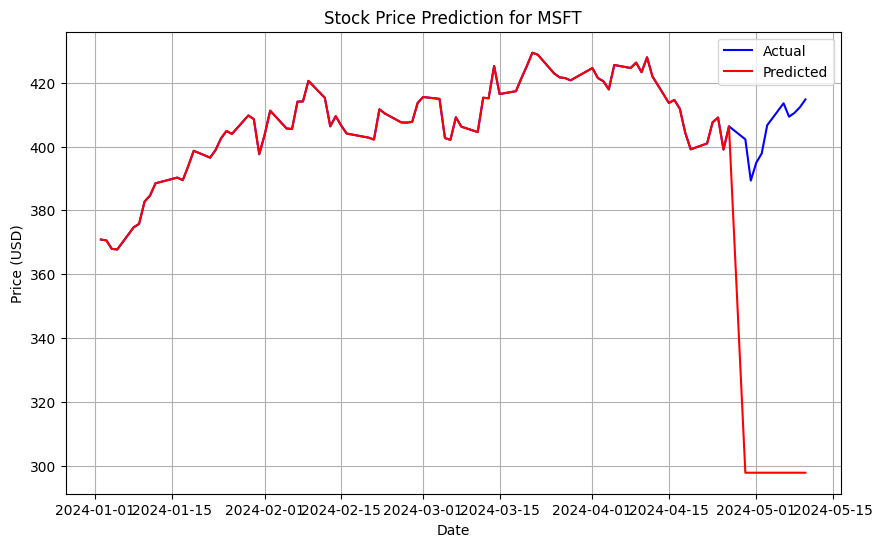

In [256]:
import matplotlib.pyplot as plt
# Create a new figure
plt.figure(figsize=(10, 6))


# Plot the actual values
plt.plot(filtered_data.index[-days_to_predict*10:], filtered_data["close"].tail(days_to_predict*10), color='blue', label='Actual')


# Plot the predicted values
filtered_data_predicted = filtered_data_predict.loc[mask]
plt.plot(filtered_data_predicted.index, filtered_data_predicted["close"], color='red', label='Predicted')


print(recent_data.index[-days_to_predict:])

# Get the sentiment values corresponding to the targets
sentiments = merged_data['Article sentiment']

## Plot the sentiment values as colored dots on the actual values
#for i in range(len(sentiments)):
#    if sentiments[i] == 1:
#        plt.scatter(dates[i], merged_data.values[i], color='green')
#    elif sentiments[i] == -1:
#        plt.scatter(dates[i], merged_data.values[i], color='red')
#    else:
#        #plt.scatter(dates[i], merged_data.values[i], color='gray')
#        pass

# Set the plot title and labels
plt.title(f'Stock Price Prediction for {TICKER}')
plt.xlabel('Date')
plt.ylabel('Price (USD)')

# Show legend
plt.legend()

# Add grid
plt.grid(True)

# Show the plot
plt.show()

In [203]:
recent_data["close"].tail(days_to_predict)

2024-04-26    297.845184
2024-04-26    297.845184
2024-04-26    297.845184
2024-04-26    297.845184
2024-04-26    297.845184
2024-04-26    297.845184
2024-04-27    297.845184
2024-04-28    297.845184
2024-04-29    297.845184
2024-04-30    297.845184
Name: close, dtype: float64

In [107]:
# Define a backtesting period
backtest_start = "2023-01-01"
backtest_end = "2024-01-01"

# Retrieve historical data for backtesting
backtest_data = si.get_data(TICKER, start_date=backtest_start, end_date=backtest_end)

if "MA_10" not in backtest_data.columns: # Run this block only once
    backtest_data["MA_10"] = backtest_data["close"].rolling(window=10).mean()  # 10-day moving average
    # Drop rows with NaN in 'MA_10'
    backtest_data = backtest_data.dropna(subset=['MA_10'])
    # backtest_data["Article sentiment"] = get_ticker_news_sentiment(ticker_symbol) # fix in the future
    backtest_data["Article sentiment"] = 0 # Dummy value for now, all neutral news sentiments


# Create future price targets for backtesting
backtest_data["future_stock_price"] = backtest_data["close"].shift(-1)

# Rename column
backtest_data = backtest_data.rename(columns={"volume": "trading_volume"})


print(backtest_data)

# Drop NaN values
backtest_features = backtest_data[["close", "trading_volume", "Article sentiment", "MA_10"]]
backtest_target = backtest_data["future_stock_price"].dropna()

# Normalize backtesting features
backtest_features_scaled = scaler.transform(backtest_features.dropna())

# Assuming model is your trained model
backtest_predictions = model.predict(backtest_features_scaled[:len(backtest_target)])

# Calculate metrics to assess performance

mse = mean_squared_error(backtest_target, backtest_predictions)
mae = mean_absolute_error(backtest_target, backtest_predictions)

print(f"Backtesting MSE: {mse}")
print(f"Backtesting MAE: {mae}")


                  open        high         low       close    adjclose  \
2023-01-17  237.970001  240.910004  237.089996  240.350006  237.797821   
2023-01-18  241.570007  242.380005  235.520004  235.809998  233.306030   
2023-01-19  233.779999  235.520004  230.679993  231.929993  229.467224   
2023-01-20  234.860001  240.740005  234.509995  240.220001  237.669189   
2023-01-23  241.100006  245.169998  239.649994  242.580002  240.004135   
...                ...         ...         ...         ...         ...   
2023-12-22  373.679993  375.179993  372.709991  374.579987  373.888580   
2023-12-26  375.000000  376.940002  373.500000  374.660004  373.968445   
2023-12-27  373.690002  375.059998  372.809998  374.070007  373.379547   
2023-12-28  375.369995  376.459991  374.160004  375.279999  374.587280   
2023-12-29  376.000000  377.160004  373.480011  376.040009  375.345886   

            trading_volume ticker       MA_10  Article sentiment  \
2023-01-17        29831300   MSFT  232.5750

# Step 7: Stock Price Prediction

The plot below shows the actual and predicted stock prices. The actual prices are shown in blue and the predicted prices are shown in red.


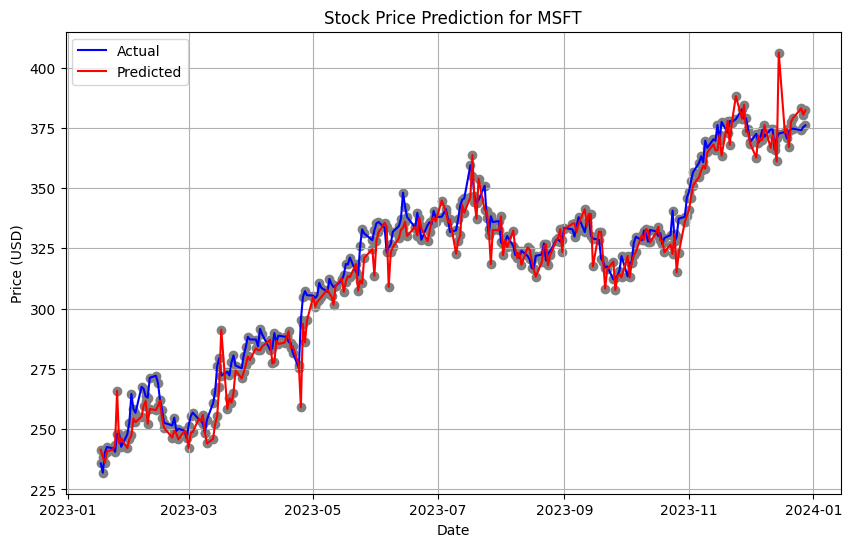

In [108]:
import matplotlib.pyplot as plt
# Create a new figure
plt.figure(figsize=(10, 6))

# Get the dates corresponding to the targets
dates = backtest_data.index[:len(backtest_target)]

# Plot the actual values
plt.plot(dates, backtest_target.values, color='blue', label='Actual')

# Plot the predicted values
plt.plot(dates, backtest_predictions, color='red', label='Predicted')

# Get the sentiment values corresponding to the targets
sentiments = backtest_data['Article sentiment'][:len(backtest_target)]

# Plot the sentiment values as colored dots on the predicted values
for i in range(len(sentiments)):
    if sentiments[i] == 1:
        plt.scatter(dates[i], backtest_predictions[i], color='green')
    elif sentiments[i] == -1:
        plt.scatter(dates[i], backtest_predictions[i], color='red')
    else:
        plt.scatter(dates[i], backtest_predictions[i], color='gray')

# Plot the sentiment values as colored dots on the actual values
for i in range(len(sentiments)):
    if sentiments[i] == 1:
        plt.scatter(dates[i], backtest_target.values[i], color='green')
    elif sentiments[i] == -1:
        plt.scatter(dates[i], backtest_target.values[i], color='red')
    else:
        plt.scatter(dates[i], backtest_target.values[i], color='gray')

# Set the plot title and labels
plt.title(f'Stock Price Prediction for {TICKER}')
plt.xlabel('Date')
plt.ylabel('Price (USD)')

# Show legend
plt.legend()

# Add grid
plt.grid(True)

# Show the plot
plt.show()

# Step 8: Implement Online Learning (Continuous Model Updates) (not implemented yet)
To implement a form of online learning, you need to define a process to update the model with new incoming data, thus allowing the model to continuously learn and adapt to changing market conditions.

Collect New Data: Fetch recent stock data and news articles. Align the news sentiment with stock prices.
Feature Engineering and Normalization: Ensure new data is prepared similarly to the original training data, including feature normalization.
Update the Model: Use the new data to continue training the model, simulating online learning. This may involve retraining the model for a few epochs with recent data.
Performance Monitoring: Track key metrics like MSE and Mean Absolute Error (MAE) to detect model drift. Define thresholds to trigger retraining when necessary.

In [9]:
'''
from datetime import datetime, timedelta
from yahoo_fin import news
'''

'\nfrom datetime import datetime, timedelta\nfrom yahoo_fin import news\n'

# Step 9: Continuous Monitoring and Model Drift Detection (not implemented yet)
Given the dynamic nature of stock markets, it's critical to continuously monitor the model's performance to detect model drift (when the model's predictions degrade due to changing market conditions).

Monitoring performance over time helps you understand when the model may need retraining or when it's experiencing drift. You might consider setting thresholds for acceptable performance levels and triggering retraining when those thresholds are exceeded.

In [10]:
'''
# Define a function to monitor model performance over time
def monitor_performance(model, scaler, feature_data, target_data):
    # Normalize the feature data
    feature_data_scaled = scaler.transform(feature_data)
    
    # Make predictions
    predictions = model.predict(feature_data_scaled)
    
    # Calculate errors
    mse = mean_squared_error(target_data, predictions)
    mae = mean_absolute_error(target_data, predictions)
    
    return mse, mae

# Example: Monitor model performance with new data
new_features = new_merged_data[["close", "trading_volume", "sentiment", "MA_10"]].dropna()
new_targets = new_merged_data["future_stock_price"].dropna()

mse, mae = monitor_performance(model, scaler, new_features, new_targets)

print(f"New data MSE: {mse}")
print(f"New data MAE: {mae}")
'''


'\n# Define a function to monitor model performance over time\ndef monitor_performance(model, scaler, feature_data, target_data):\n    # Normalize the feature data\n    feature_data_scaled = scaler.transform(feature_data)\n    \n    # Make predictions\n    predictions = model.predict(feature_data_scaled)\n    \n    # Calculate errors\n    mse = mean_squared_error(target_data, predictions)\n    mae = mean_absolute_error(target_data, predictions)\n    \n    return mse, mae\n\n# Example: Monitor model performance with new data\nnew_features = new_merged_data[["close", "trading_volume", "sentiment", "MA_10"]].dropna()\nnew_targets = new_merged_data["future_stock_price"].dropna()\n\nmse, mae = monitor_performance(model, scaler, new_features, new_targets)\n\nprint(f"New data MSE: {mse}")\nprint(f"New data MAE: {mae}")\n'

# Step 10: Deployment and Automation (not implemented yet)
Deploying the model in a production environment requires automation to collect new data, update the model, and trigger retraining when necessary. Consider using a cloud-based environment or automated pipelines to streamline this process.

In [11]:
'''
# Define a pipeline for automated data collection, training, and model updating
def automated_training_pipeline(ticker_symbol, model, scaler):
    # Step 1: Collect new stock data
    new_ticker_data = si.get_data(ticker_symbol, start_date=datetime.now() - timedelta(days=7))
    
    # Step 2: Collect new news data and analyze sentiment
    new_news_data = news.get_yf_rss(ticker_symbol)
    new_news_sentiments = [analyze_sentiment(item["title"]) for item in new_news_data]
    new_news_df = pd.DataFrame({
        "timestamp": [item["pubDate"] for item in new_news_data],
        "sentiment": new_news_sentiments,
    }).resample("D", on="timestamp").mean()

    # Step 3: Merge stock data with news sentiment
    new_merged_data = pd.merge(
        new_ticker_data,
        new_news_df,
        left_on="date",
        right_index=True,
        how="left",
    ).fillna(0)

    # Step 4: Normalize features and continue training
    new_features = new_merged_data[["close", "trading_volume", "sentiment", "MA_10"]].dropna()
    new_targets = new_merged_data["close"].shift(-1).dropna()
    new_features_scaled = scaler.transform(new_features)

    # Step 5: Continue training the model with new data
    model.fit(new_features_scaled, new_targets, epochs=5, batch_size=32)

    return model
'''

'\n# Define a pipeline for automated data collection, training, and model updating\ndef automated_training_pipeline(ticker_symbol, model, scaler):\n    # Step 1: Collect new stock data\n    new_stock_data = si.get_data(ticker_symbol, start_date=datetime.now() - timedelta(days=7))\n    \n    # Step 2: Collect new news data and analyze sentiment\n    new_news_data = news.get_yf_rss(ticker_symbol)\n    new_news_sentiments = [analyze_sentiment(item["title"]) for item in new_news_data]\n    new_news_df = pd.DataFrame({\n        "timestamp": [item["pubDate"] for item in new_news_data],\n        "sentiment": new_news_sentiments,\n    }).resample("D", on="timestamp").mean()\n\n    # Step 3: Merge stock data with news sentiment\n    new_merged_data = pd.merge(\n        new_stock_data,\n        new_news_df,\n        left_on="date",\n        right_index=True,\n        how="left",\n    ).fillna(0)\n\n    # Step 4: Normalize features and continue training\n    new_features = new_merged_data[["close

This pipeline demonstrates a simplified approach to automating data collection, sentiment analysis, feature engineering, and model retraining. Consider more robust infrastructure, such as containerization with Docker, cloud-based workflows, or CI/CD (Continuous Integration/Continuous Deployment) pipelines for production-ready solutions.

Key Considerations
Model Generalization: Ensure that your model does not overfit to specific patterns or short-term trends. Techniques like dropout, early stopping, and regularization can help.
Model Drift: Regularly check for model drift and retrain when necessary.
Data Quality and Consistency: Ensure that incoming data is accurate and consistent.
Scalability and Robustness: Design the solution to handle large-scale data and unexpected scenarios.